In [26]:
import matplotlib.pyplot as plt
import numpy as np
import json

import os

In [27]:
def create_experiment_dict(folder_path):
    experiment_dict = {}
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.json'):
            file_name_sections = file_name.split('_')
            unique_id = file_name_sections[-1]
            subject_id = file_name_sections[-2]
            experiment_name = '_'.join(file_name_sections[:-2])
            experiment_name = experiment_name.lower()
            
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r') as file:
                data = json.load(file)
            
            if experiment_name not in experiment_dict:
                experiment_dict[experiment_name] = {}
            
            experiment_dict[experiment_name][subject_id] = data
    
    return experiment_dict


In [28]:
def merge_large_experiment(folder_path):
    experiment_dict = {}

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.json'):
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r') as file:
                data = json.load(file)
                for subject_id, subject_data in data.items():
                    for experiment_name, experiment_data in subject_data.items():
                        if experiment_name not in experiment_dict:
                            experiment_dict[experiment_name] = {}
                        experiment_dict[experiment_name][subject_id] = experiment_data
    return experiment_dict

def output_experiment_dict(dict):
    with open("all_experiments", 'w') as file:
        json.dump(dict, file, indent=4)

In [29]:
# path = "/home/ubuntu/portiloop-training/results_adap_exp_1"
# path = '/home/ubuntu/portiloop-training/results_adap_exp_full'
# path = '/home/ubuntu/portiloop-training/results_adap_exp_LA7_folds'
# path = '/home/ubuntu/portiloop-training/results_adap_exp_adap_folds'
path_portinight = '/home/ubuntu/portiloop-training/results_adap_portinight_3'
path = '/home/ubuntu/portiloop-training/results_adap_exp_all_3'
experiment_dict = merge_large_experiment(path)
figure_path = '/home/ubuntu/adaptation-paper/figures'


### Adding the Age and Gender information to the subjects

In [30]:
subjects = list(experiment_dict[list(experiment_dict.keys())[0]].keys())
if 'averages' in subjects:
    subjects.remove('averages')

dataset_path = '/project/MASS/mass_spindles_dataset'

with open(os.path.join(dataset_path, 'subject_info.csv'), 'r') as file:
    subject_info = file.read().split('\n')
    subject_info = {subject.split(',')[0]: {'age': subject.split(',')[1], 'gender': subject.split(',')[2]} for subject in subject_info if subject}

# Add subject info to experiment dict
for experiment_name, experiment_data in experiment_dict.items():
    for subject_id, subject_data in experiment_data.items():
        if subject_id not in subjects:
            continue
        subject_data['age'] = subject_info[subject_id]['age']
        subject_data['gender'] = subject_info[subject_id]['gender']

In [31]:
# Print all the ages of each subject
for subject_id in subjects:
    print(subject_id, experiment_dict[list(experiment_dict.keys())[0]][subject_id]['age'])

01-01-0001 57
01-03-0012 52
01-01-0040 63
01-05-0014 23
01-03-0040 21
01-03-0051 55
01-03-0016 60
01-01-0010 62
01-03-0033 23
01-03-0001 65
01-01-0042 62
01-03-0031 56
01-01-0026 63
01-03-0037 54
01-03-0010 23
01-01-0037 60
01-05-0025 23
01-05-0016 27
01-05-0008 21
01-03-0013 55
01-03-0019 61
01-03-0018 63
01-01-0038 61
01-01-0014 64
01-05-0019 25
01-01-0011 72
01-01-0028 57
01-05-0012 27
01-01-0003 64
01-01-0033 63
01-02-0006 28
01-03-0014 51
01-02-0008 24
01-02-0003 19
01-01-0002 68
01-03-0030 50
01-03-0053 60
01-03-0022 26
01-03-0044 27
01-03-0032 61
01-05-0017 20
01-05-0021 21
01-03-0005 23
01-02-0009 21
01-01-0034 60
01-05-0001 24
01-01-0015 64
01-03-0004 26
01-01-0031 61
01-05-0010 25
01-02-0010 30
01-01-0022 71
01-01-0029 57
01-03-0039 60
01-01-0025 63
01-03-0007 21
01-01-0012 69
01-05-0009 22
01-03-0054 30
01-01-0007 57
01-03-0026 68
01-03-0025 27
01-01-0013 67
01-05-0007 23
01-05-0015 25
01-01-0021 69
01-02-0002 22
01-01-0041 71
01-05-0018 27
01-05-0002 25
01-05-0022 21
01-02-

Extracting All Results
---------------------------------------------

In [32]:
experiment_dict['config_0']['01-01-0001']['metrics'].keys()

dict_keys(['ss_metrics', 'ss_confusion_matrix', 'detect_spindle_metrics', 'detect_spindle_metrics_ola7gt', 'online_lacourse_metrics'])

In [33]:
def average_experiment(exp_dict, old=True):
    for experiment_name, subject_data in exp_dict.items():
        averages = {}
        avg_f1, std_f1, f1_vals = average_one_metric(subject_data, 'spindle detection', 'f1')
        avg_precision, std_precision, precision_vals = average_one_metric(subject_data, 'spindle detection', 'precision')
        avg_recall, std_recall, recall_vals = average_one_metric(subject_data, 'spindle detection', 'recall')
        avg_ss_acc, std_ss_acc, acc_vals = average_one_metric(subject_data, 'sleep scoring', 'accuracy')

        avg_f1_ola7, std_f1_ola7, f1_vals_ola7 = average_one_metric(subject_data, 'spindle_detection_2', 'f1')

        avg_wamsley_f1, std_wamsley_f1, lac_vals = average_one_metric(subject_data, 'spindle wamsley metrics', 'f1')

        if old:
            avg_f1_old, std_f1_old, old_f1_vals = average_one_metric(subject_data, 'spindle detection', 'f1', age='old')
            avg_wamsley_f1_old, std_wamsley_f1_old, old_f1_lac_vals = average_one_metric(subject_data, 'spindle wamsley metrics', 'f1', age='old')
        
        avg_f1_young, std_f1_young, young_f1_vals = average_one_metric(subject_data, 'spindle detection', 'f1', age='young')
        avg_wamsley_f1_young, std_wamsley_f1_young, young_f1_lac_vals = average_one_metric(subject_data, 'spindle wamsley metrics', 'f1', age='young')

        averages['f1'] = (avg_f1, std_f1)
        averages['f1_vals'] = f1_vals
        averages['f1_ola7'] = (avg_f1_ola7, std_f1_ola7)
        averages['f1_ola7_vals'] = f1_vals_ola7
        averages['precision'] = (avg_precision, std_precision)
        averages['precision_vals'] = precision_vals
        averages['recall'] = (avg_recall, std_recall)
        averages['recall_vals'] = recall_vals
        averages['ss_acc'] = (avg_ss_acc, std_ss_acc)
        averages['ss_acc_vals'] = acc_vals
        averages['wamsley_f1'] = (avg_wamsley_f1, std_wamsley_f1)
        averages['wamsley_f1_vals'] = lac_vals

        averages['f1_young'] = (avg_f1_young, std_f1_young)
        averages['young_f1_vals'] = young_f1_vals

        averages['wamsley_f1_young'] = (avg_wamsley_f1_young, std_wamsley_f1_young)
        averages['wamsley_f1_young_vals'] = young_f1_lac_vals

        if old:
            averages['f1_old'] = (avg_f1_old, std_f1_old)
            averages['old_f1_vals'] = old_f1_vals
            averages['wamsley_f1_old'] = (avg_wamsley_f1_old, std_wamsley_f1_old)
            averages['wamsley_f1_old_vals'] = old_f1_lac_vals

        exp_dict[experiment_name]['averages'] = averages

    # Get the improvements of each experiment over the baseline (first experiment)
    for index, (experiment_name, subject_data) in enumerate(exp_dict.items()):
        print(experiment_name)
        if index == 0:
            baseline = subject_data
            continue
        improvement = {}
        avg_f1_improvement, std_f1_improvement, min_f1_improvement, f1_improvement = get_improvement(baseline, subject_data, 'spindle detection', 'f1')
        avg_precision_improvement, std_precision_improvement, min_precision_improvement, precision_improvement = get_improvement(baseline, subject_data, 'spindle detection', 'precision')
        avg_recall_improvement, std_recall_improvement, min_recall_improvement, recall_improvement = get_improvement(baseline, subject_data, 'spindle detection', 'recall')
        avg_ss_acc_improvement, std_ss_acc_improvement, min_ss_acc_improvement, acc_improvement = get_improvement(baseline, subject_data, 'sleep scoring', 'accuracy')
        avg_wamsley_f1_improvement, std_wamsley_f1_improvement, min_wamsley_f1_improvement, lac_improvement = get_improvement(baseline, subject_data, 'spindle wamsley metrics', 'f1')

        if old:
            avg_f1_old_improvement, std_f1_old_improvement, min_f1_old_improvement, f1_old_improvement = get_improvement(baseline, subject_data, 'spindle detection', 'f1', age='old')
            avg_wamsley_f1_old_improvement, std_wamsley_f1_old_improvement, min_wamsley_f1_old_improvement, old_f1_lac_improvement = get_improvement(baseline, subject_data, 'spindle wamsley metrics', 'f1', age='old')
        
        avg_wamsley_f1_young_improvement, std_wamsley_f1_young_improvement, min_wamsley_f1_young_improvement, young_f1_lac_improvement = get_improvement(baseline, subject_data, 'spindle wamsley metrics', 'f1', age='young')
        avg_f1_young_improvement, std_f1_young_improvement, min_f1_young_improvement, f1_young_improvement = get_improvement(baseline, subject_data, 'spindle detection', 'f1', age='young')

        improvement['f1'] = (avg_f1_improvement, std_f1_improvement, min_f1_improvement, f1_improvement)
        improvement['precision'] = (avg_precision_improvement, std_precision_improvement, min_precision_improvement, precision_improvement)
        improvement['recall'] = (avg_recall_improvement, std_recall_improvement, min_recall_improvement, recall_improvement)
        improvement['ss_acc'] = (avg_ss_acc_improvement, std_ss_acc_improvement, min_ss_acc_improvement, acc_improvement)
        improvement['wamsley_f1'] = (avg_wamsley_f1_improvement, std_wamsley_f1_improvement, min_wamsley_f1_improvement, lac_improvement)
        improvement['f1_young'] = (avg_f1_young_improvement, std_f1_young_improvement, min_f1_young_improvement, f1_young_improvement)
        improvement['wamsley_f1_young'] = (avg_wamsley_f1_young_improvement, std_wamsley_f1_young_improvement, min_wamsley_f1_young_improvement, young_f1_lac_improvement)

        if old:
            improvement['f1_old'] = (avg_f1_old_improvement, std_f1_old_improvement, min_f1_old_improvement, f1_old_improvement)
            improvement['wamsley_f1_old'] = (avg_wamsley_f1_old_improvement, std_wamsley_f1_old_improvement, min_wamsley_f1_old_improvement, old_f1_lac_improvement)

        exp_dict[experiment_name][f'improvement'] = improvement

    return exp_dict
        
metric_types = {
    'sleep scoring': 'ss_metrics',
    'confusion matrix': 'ss_confusion_matrix',
    'spindle detection': 'detect_spindle_metrics',
    'spindle_detection_2': 'detect_spindle_metrics_ola7gt',
    'spindle wamsley metrics': 'online_lacourse_metrics',
}

def average_one_metric(single_exp_dict, metric_type, metric_name, age=None):
    '''
    Takes in a single experiment and metric name and returns the average of that metric for all subjects
    '''
    
    if age == 'old':
        age_filter = lambda x: int(x) > 30
    elif age == 'young':
        age_filter = lambda x: int(x) <= 30
    else:
        age_filter = lambda x: True

    metric = []
    for name, data in single_exp_dict.items():
        if name == 'averages':
            continue
        if not age_filter(data['age']):
            continue
        data = data['metrics'][metric_types[metric_type]]
        if metric_name in data:
            metric.append(data[metric_name])

    metric = np.array(metric)
    average = np.mean(metric, axis=0)
    std = np.std(metric, axis=0)

    return average, std, metric

def get_improvement(exp1_dict, exp2_dict, metric_type, metric_name, age=None):
    '''
    Takes in two experiment dictionaries and returns the improvement of the second over the first
    '''
    _, _, vals1 = average_one_metric(exp1_dict, metric_type, metric_name, age)
    _, _, vals2 = average_one_metric(exp2_dict, metric_type, metric_name, age)

    improvements = vals2 - vals1
    avg_improvement = np.mean(improvements)
    std_improvement = np.std(improvements)
    min_improvement = np.min(improvements)
    return avg_improvement, std_improvement, min_improvement, improvements


In [34]:
len(list(experiment_dict['config_0'].keys()))

140

In [35]:
# Check Old
check_old = any([int(experiment_dict['config_0'][subject_id]['age']) > 30 for subject_id in subjects])
new_dict = average_experiment(experiment_dict, old=check_old)

config_0
config_3
config_4
config_5
config_6
config_7
config_8
config_9
config_10


Print a nice table with all the average metrics

In [36]:
from tabulate import tabulate

# Get the list of all metrics
metrics = list(next(iter(experiment_dict.values()))['averages'].keys())

# Initialize a dictionary to hold the data
data = {metric: [] for metric in metrics if 'vals' not in metric}

# Populate the data dictionary
for experiment_name, experiment_data in experiment_dict.items():
    averages = experiment_data.get('averages', {})
    for metric_name, item in averages.items():
        if isinstance(item, tuple):
            average, std = item
        else:
            continue
        data[metric_name].append(f"{average:.2f} ± {std:.2f}")

# Convert the data dictionary to a table data list
table_data = [[metric_name] + data[metric_name] for metric_name in metrics if 'vals' not in metric_name]

headers = ['Metric'] + list(experiment_dict.keys())
table = tabulate(table_data, headers, tablefmt='grid')
print(table)

+------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
| Metric           | config_0    | config_3    | config_4    | config_5    | config_6    | config_7    | config_8    | config_9    | config_10   |
+==================+=============+=============+=============+=============+=============+=============+=============+=============+=============+
| f1               | 0.51 ± 0.14 | 0.54 ± 0.14 | 0.53 ± 0.15 | 0.50 ± 0.14 | 0.51 ± 0.14 | 0.50 ± 0.13 | 0.53 ± 0.14 | 0.53 ± 0.15 | 0.53 ± 0.14 |
+------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
| f1_ola7          | 0.48 ± 0.15 | 0.51 ± 0.14 | 0.48 ± 0.15 | 0.49 ± 0.13 | 0.44 ± 0.14 | 0.49 ± 0.13 | 0.51 ± 0.14 | 0.48 ± 0.14 | 0.51 ± 0.14 |
+------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+

In [79]:
table_data_new = [headers] + table_data

# Remove all but the first three columns
table_data_new = [[row[0], row[1], row[2], row[4], row[6]] for row in table_data_new]
table_data_new[0][1] = "Baseline"
table_data_new[0][2] = "AdaThresh (No SS)"
table_data_new[0][3] = "Finetuning"
table_data_new[0][4] = "AdaThresh + Finetuning"

def array_to_latex(array):
    latex_code = "\\begin{table}[h!]\n"
    latex_code += "\\centering\n"
    latex_code += "\\begin{tabular}{|" + "|".join(["c"] * len(array[0])) + "|}\n"
    latex_code += "\\hline\n"
    for row in array:
        latex_code += " & ".join(map(str, row)) + " \\\\\n"
        latex_code += "\\hline\n"
    latex_code += "\\end{tabular}\n"
    latex_code += "\\caption{Caption here}\n"  # Add your caption here
    latex_code += "\\label{tab:my_table}\n"  # Add your label here
    latex_code += "\\end{table}"
    print(latex_code)

array_to_latex(table_data_new)

\begin{table}[h!]
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
Metric & AdaThresh (No SS) & Finetuning & AdaThresh + Finetuning & config_5 \\
\hline
f1 & 0.43 ± 0.17 & 0.50 ± 0.10 & 0.48 ± 0.13 & 0.48 ± 0.12 \\
\hline
precision & 0.43 ± 0.15 & 0.41 ± 0.10 & 0.41 ± 0.13 & 0.38 ± 0.12 \\
\hline
recall & 0.56 ± 0.29 & 0.66 ± 0.15 & 0.66 ± 0.22 & 0.70 ± 0.11 \\
\hline
ss_acc & 0.66 ± 0.11 & 0.66 ± 0.11 & 0.69 ± 0.09 & 0.69 ± 0.09 \\
\hline
wamsley_f1 & 0.76 ± 0.20 & 0.76 ± 0.20 & 0.76 ± 0.20 & 0.76 ± 0.20 \\
\hline
f1_old & 0.40 ± 0.20 & 0.49 ± 0.13 & 0.46 ± 0.17 & 0.46 ± 0.15 \\
\hline
f1_young & 0.47 ± 0.09 & 0.51 ± 0.04 & 0.51 ± 0.04 & 0.51 ± 0.05 \\
\hline
wamsley_f1_old & 0.70 ± 0.25 & 0.70 ± 0.25 & 0.70 ± 0.25 & 0.70 ± 0.25 \\
\hline
wamsley_f1_young & 0.83 ± 0.06 & 0.83 ± 0.06 & 0.83 ± 0.06 & 0.83 ± 0.06 \\
\hline
\end{tabular}
\caption{Caption here}
\label{tab:my_table}
\end{table}


Show the data for the Wamsley online performance

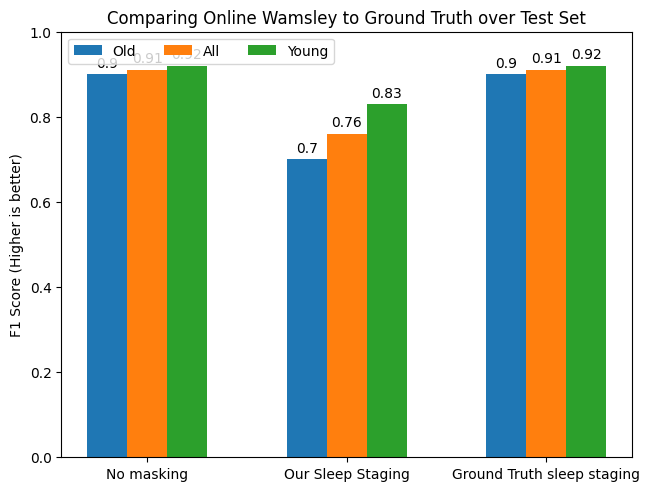

In [54]:
# Bar chart Comparing Wamsley F1 scores
config_names = ("config_4", "config_5", "config_6")
experiment_names = ("No masking", "Our Sleep Staging", "Ground Truth sleep staging")
wamsley_scores = {
    "Old": (
        round(new_dict[config_names[0]]['averages']['wamsley_f1_old'][0], 2),
        round(new_dict[config_names[1]]['averages']['wamsley_f1_old'][0], 2),
        round(new_dict[config_names[2]]['averages']['wamsley_f1_old'][0], 2)
    ),
    "All": (
        round(new_dict[config_names[0]]['averages']['wamsley_f1'][0], 2),
        round(new_dict[config_names[1]]['averages']['wamsley_f1'][0], 2),
        round(new_dict[config_names[2]]['averages']['wamsley_f1'][0], 2)
    ),
    "Young": (
        round(new_dict[config_names[0]]['averages']['wamsley_f1_young'][0], 2),
        round(new_dict[config_names[1]]['averages']['wamsley_f1_young'][0], 2),
        round(new_dict[config_names[2]]['averages']['wamsley_f1_young'][0], 2)
    ),
}

x = np.arange(len(experiment_names))
width = 0.20
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, scores in wamsley_scores.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, scores, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('F1 Score (Higher is better)')
ax.set_title('Comparing Online Wamsley to Ground Truth over Test Set')
ax.set_xticks(x + width, experiment_names)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1)

plt.show()

In [59]:
new_dict.keys()

dict_keys(['config_0', 'config_1', 'config_2', 'config_3', 'config_4', 'config_5', 'config_6'])

[1 2 3]


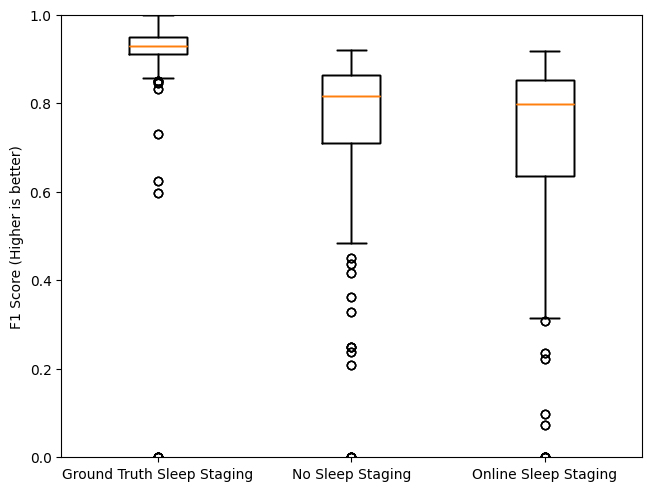

In [12]:
# Bar chart Comparing Wamsley F1 scores
config_names = ("config_2", "config_0", "config_1")
experiment_names = ("Ground Truth Sleep Staging", "No Sleep Staging", "Online Sleep Staging")
wamsley_scores = {
    # "Old": (
    #     new_dict[config_names[0]]['averages']['wamsley_f1_old_vals'],
    #     # new_dict[config_names[1]]['averages']['wamsley_f1_old_vals'],
    #     # new_dict[config_names[2]]['averages']['wamsley_f1_old_vals']
    # ),
    "All": (
        new_dict[config_names[0]]['averages']['wamsley_f1_vals'],
        new_dict[config_names[1]]['averages']['wamsley_f1_vals'],
        new_dict[config_names[2]]['averages']['wamsley_f1_vals']
    ),
    # "Young": (
    #     new_dict[config_names[0]]['averages']['wamsley_f1_young_vals'],
    #     new_dict[config_names[1]]['averages']['wamsley_f1_young_vals'],
    #     new_dict[config_names[2]]['averages']['wamsley_f1_young_vals']
    # ),
}

x = np.arange(len(experiment_names)) + 1
width = 0.20
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for i in range(len(config_names)):
    for attribute, scores in wamsley_scores.items():
        offset = width * multiplier
        # Show a boxplot using the values
        ax.boxplot(scores)
        multiplier += 1

print(x)
ax.set_ylabel('F1 Score (Higher is better)')
# ax.set_title('Comparing LA7 Performance with different Sleep Staging Methods')
ax.set_xticks(x, experiment_names)
# ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1)

plt.show()

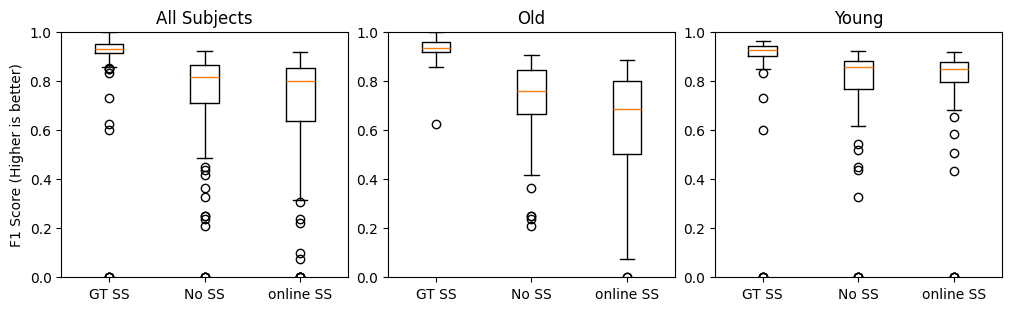

In [57]:
# Bar chart Comparing Wamsley F1 scores
config_names = ("config_2", "config_0", "config_1")
experiment_names = ("GT SS", "No SS", "online SS")
wamsley_scores = {
    "All Subjects": (
        new_dict[config_names[0]]['averages']['wamsley_f1_vals'],
        new_dict[config_names[1]]['averages']['wamsley_f1_vals'],
        new_dict[config_names[2]]['averages']['wamsley_f1_vals']
    ),
    "Old": (
        new_dict[config_names[0]]['averages']['wamsley_f1_old_vals'],
        new_dict[config_names[1]]['averages']['wamsley_f1_old_vals'],
        new_dict[config_names[2]]['averages']['wamsley_f1_old_vals']
    ),
    "Young": (
        new_dict[config_names[0]]['averages']['wamsley_f1_young_vals'],
        new_dict[config_names[1]]['averages']['wamsley_f1_young_vals'],
        new_dict[config_names[2]]['averages']['wamsley_f1_young_vals']
    ),
}

x = np.arange(len(experiment_names)) + 1
width = 0.20
multiplier = 0

fig, axs = plt.subplots(1, 3, figsize=(10, 3), layout='constrained')

for i, (attribute, scores) in enumerate(wamsley_scores.items()):
    for j in range(len(config_names)):
        offset = width * j
        # Show a boxplot using the values
        axs[i].boxplot(scores[j], positions=[j+1], widths=0.3)
        axs[i].set_title(attribute)
        # axs[i].set_ylabel('F1 Score (Higher is better)')
        axs[i].set_xticks(x, experiment_names)
        axs[i].set_ylim(0, 1)

# Set The y axis label for the first plot
axs[0].set_ylabel('F1 Score (Higher is better)')

#  ax.set_title('Comparing LA7 Performance with different Sleep Staging Methods')
ax.set_xticks(x, experiment_names)
# ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1)

plt.show()

### Lacourse F1 VS SS Acc

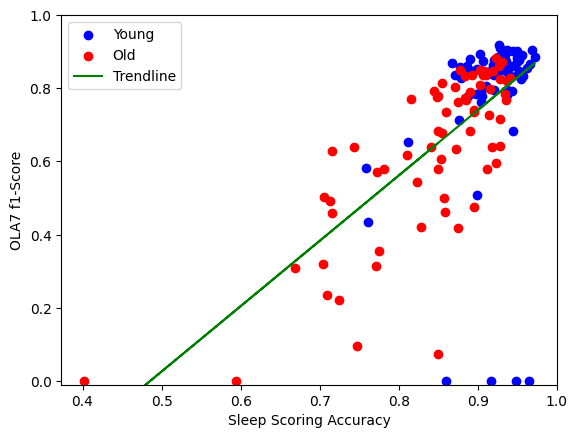

In [40]:
# Get the list of all metrics
experiment_of_interest = 'config_1'

# For each subject, get the f1 score for baseline and for adapt threshold
baseline_ss_young = [new_dict[experiment_of_interest][subject]['metrics']['ss_metrics']['accuracy'] for subject in subjects if int(new_dict[experiment_of_interest][subject]['age']) <= 30]
baseline_ss_old = [new_dict[experiment_of_interest][subject]['metrics']['ss_metrics']['accuracy'] for subject in subjects if int(new_dict[experiment_of_interest][subject]['age']) > 30]
lacoursef1_young = [new_dict[experiment_of_interest][subject]['metrics']['online_lacourse_metrics']['f1'] for subject in subjects if int(new_dict[experiment_of_interest][subject]['age']) <= 30]
lacoursef1_old = [new_dict[experiment_of_interest][subject]['metrics']['online_lacourse_metrics']['f1'] for subject in subjects if int(new_dict[experiment_of_interest][subject]['age']) > 30]

# Plot the data with a different color for each age group 
fig, ax = plt.subplots()
ax.scatter(baseline_ss_young, lacoursef1_young, color='blue', label='Young')
ax.scatter(baseline_ss_old, lacoursef1_old, color='red', label='Old')

# Add a trendline for both groups
ss_both = baseline_ss_young + baseline_ss_old
lacourse_both = lacoursef1_young + lacoursef1_old
trendline = np.polyfit(ss_both, lacourse_both, 1)
trendline_fn = np.poly1d(trendline)
ax.plot(ss_both, trendline_fn(ss_both), color='green', label='Trendline')

# Set the y axis to be between 0 and 1
ax.set_ylim(-0.01, 1)

ax.set_xlabel('Sleep Scoring Accuracy')
ax.set_ylabel('OLA7 f1-Score')
ax.legend()
plt.show()


### Lacourse F1 Vs number of spindles

In [27]:
new_dict['config_0']['01-01-0001']['metrics']['online_lacourse_metrics'].keys()


dict_keys(['precision', 'recall', 'f1', 'tp', 'fp', 'fn'])

In [28]:
def get_num_spindles(metric_dict):
    return metric_dict['online_lacourse_metrics']['tp'] + metric_dict['online_lacourse_metrics']['fn']

In [53]:
# Count all the subjects who have less than 10 spindles in gt
num_spindles = [get_num_spindles(new_dict['config_0'][subject]['metrics']) for subject in subjects]
num_spindles = np.array(num_spindles)
num_spindles[num_spindles < 50].shape

(9,)

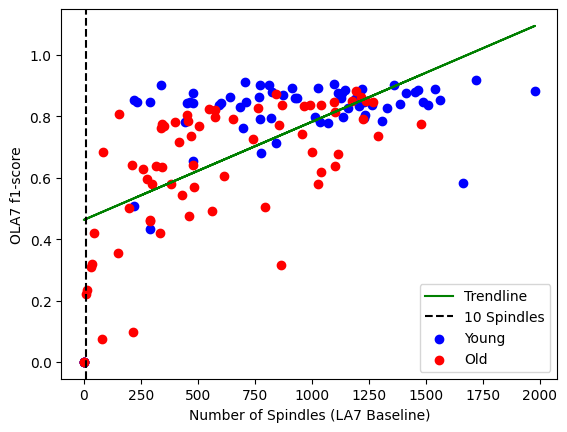

In [55]:
# Get the list of all metrics
experiment_of_interest = 'config_1'

# For each subject, get the f1 score for baseline and for adapt threshold
num_young = [get_num_spindles(new_dict[experiment_of_interest][subject]['metrics']) for subject in subjects if int(new_dict[experiment_of_interest][subject]['age']) <= 30]
num_old = [get_num_spindles(new_dict[experiment_of_interest][subject]['metrics']) for subject in subjects if int(new_dict[experiment_of_interest][subject]['age']) > 30]
lacoursef1_young = [new_dict[experiment_of_interest][subject]['metrics']['online_lacourse_metrics']['f1'] for subject in subjects if int(new_dict[experiment_of_interest][subject]['age']) <= 30]
lacoursef1_old = [new_dict[experiment_of_interest][subject]['metrics']['online_lacourse_metrics']['f1'] for subject in subjects if int(new_dict[experiment_of_interest][subject]['age']) > 30]

# Plot the data with a different color for each age group 
fig, ax = plt.subplots()

# Compute the trendline for the young and old subjects
num_spindles = np.array(num_young + num_old)
lacourse_f1 = np.array(lacoursef1_young + lacoursef1_old)
trendline = np.polyfit(num_spindles, lacourse_f1, 1)
trendline_fn = np.poly1d(trendline)
ax.plot(num_spindles, trendline_fn(num_spindles), color='green', label='Trendline')

# PLot a vertical line at 50 spindles
ax.axvline(x=10, color='black', linestyle='--', label='10 Spindles')

ax.scatter(num_young, lacoursef1_young, color='blue', label='Young')
ax.scatter(num_old, lacoursef1_old, color='red', label='Old')
ax.set_xlabel('Number of Spindles (LA7 Baseline)')
ax.set_ylabel('OLA7 f1-score')
ax.legend()
plt.show()

## Box Plot to Compare AdaThresh with Baseline 

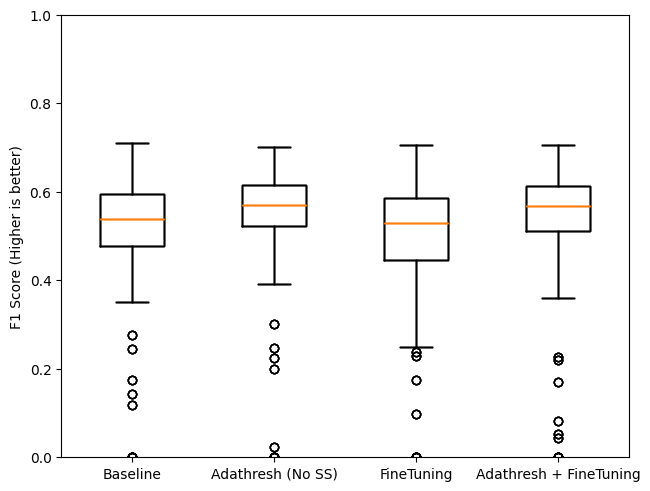

In [37]:
# Bar chart Comparing Wamsley F1 scores
config_names = ("config_0", "config_3", "config_7", "config_10")
experiment_names = ("Baseline", "Adathresh (No SS)", "FineTuning", "Adathresh + FineTuning")
wamsley_scores = {
    "All": (
        new_dict[config_names[0]]['averages']['f1_vals'],
        new_dict[config_names[1]]['averages']['f1_vals'],
        new_dict[config_names[2]]['averages']['f1_vals'],
        new_dict[config_names[3]]['averages']['f1_vals']
    ),
}

x = np.arange(len(experiment_names)) + 1
width = 0.20
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for i in range(len(config_names)):
    for attribute, scores in wamsley_scores.items():
        offset = width * multiplier
        # Show a boxplot using the values
        ax.boxplot(scores)
        multiplier += 1

ax.set_ylabel('F1 Score (Higher is better)')
# ax.set_title('Comparing AdaThresh Performance with different Sleep Staging Methods')
ax.set_xticks(x, experiment_names)
# ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1)

plt.show()

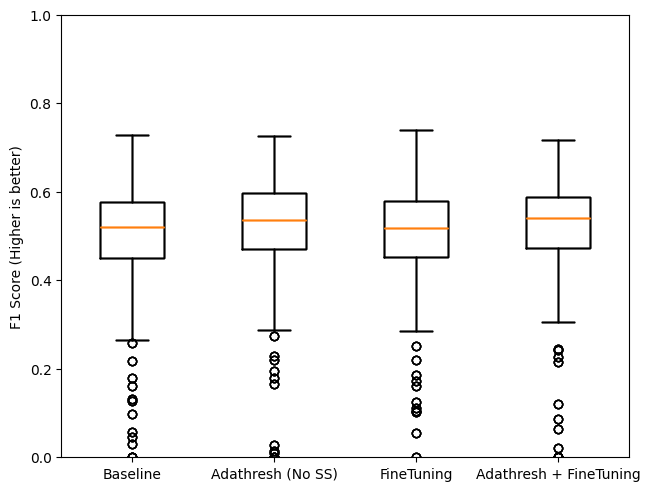

In [38]:
# Bar chart Comparing Wamsley F1 scores
config_names = ("config_0", "config_3", "config_7", "config_10")
experiment_names = ("Baseline", "Adathresh (No SS)", "FineTuning", "Adathresh + FineTuning")
wamsley_scores = {
    "All": (
        new_dict[config_names[0]]['averages']['f1_ola7_vals'],
        new_dict[config_names[1]]['averages']['f1_ola7_vals'],
        new_dict[config_names[2]]['averages']['f1_ola7_vals'],
        new_dict[config_names[3]]['averages']['f1_ola7_vals']
    ),
}

x = np.arange(len(experiment_names)) + 1
width = 0.20
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for i in range(len(config_names)):
    for attribute, scores in wamsley_scores.items():
        offset = width * multiplier
        # Show a boxplot using the values
        ax.boxplot(scores)
        multiplier += 1

ax.set_ylabel('F1 Score (Higher is better)')
# ax.set_title('Comparing AdaThresh Performance with different Sleep Staging Methods')
ax.set_xticks(x, experiment_names)
# ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1)

plt.show()

### Showing the improvement of the different finetuning parameters

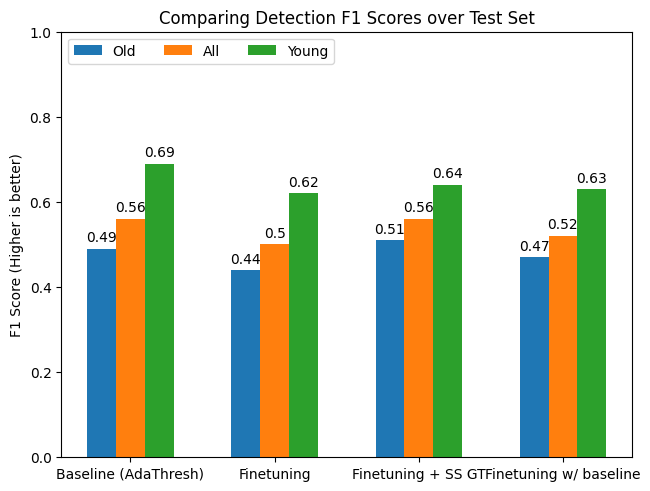

In [127]:
# Bar chart Comparing Wamsley F1 scores
experiment_names = ("Baseline (AdaThresh)", "Finetuning", "Finetuning + SS GT", "Finetuning w/ baseline")
wamsley_scores = {
    "Old": (
        round(new_dict['ADAPT_THRESHOLD_DETECTION']['averages']['f1_old'][0], 2),
        round(new_dict['TRAIN_WITH_THRESH_ADAPT']['averages']['f1_old'][0], 2),
        round(new_dict['TRAIN_WITH_SS_GT']['averages']['f1_old'][0], 2),
        round(new_dict['TRAIN_BASELINE_GT']['averages']['f1_old'][0], 2)
    ),
    "All": (
        round(new_dict['ADAPT_THRESHOLD_DETECTION']['averages']['f1'][0], 2),
        round(new_dict['TRAIN_WITH_THRESH_ADAPT']['averages']['f1'][0], 2),
        round(new_dict['TRAIN_WITH_SS_GT']['averages']['f1'][0], 2),
        round(new_dict['TRAIN_BASELINE_GT']['averages']['f1'][0], 2)
    ),
    "Young": (
        round(new_dict['ADAPT_THRESHOLD_DETECTION']['averages']['f1_young'][0], 2),
        round(new_dict['TRAIN_WITH_THRESH_ADAPT']['averages']['f1_young'][0], 2),
        round(new_dict['TRAIN_WITH_SS_GT']['averages']['f1_young'][0], 2),
        round(new_dict['TRAIN_BASELINE_GT']['averages']['f1_young'][0], 2)
    ),
}

x = np.arange(len(experiment_names))
width = 0.20
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, scores in wamsley_scores.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, scores, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('F1 Score (Higher is better)')
ax.set_title('Comparing Detection F1 Scores over Test Set for different Finetuning parameters')
ax.set_xticks(x + width, experiment_names)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 1)

plt.show()

### Graph to see where it improves or not

In [56]:
new_dict['config_0'][subjects[0]]['metrics'].keys()

dict_keys(['ss_metrics', 'ss_confusion_matrix', 'detect_spindle_metrics', 'detect_spindle_metrics_ola7gt', 'online_lacourse_metrics'])

Text(0, 0.5, 'OLA7 F1 - Spindle Detection F1')

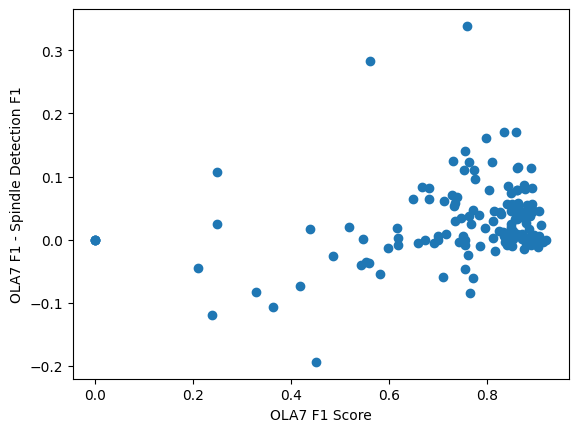

In [77]:
# Check that all the ola7 f1 scores are higher than the spindle detection f1 scores
diffs = [new_dict['config_3'][subject]['metrics']['detect_spindle_metrics']['f1'] - new_dict['config_0'][subject]['metrics']['detect_spindle_metrics']['f1'] for subject in subjects]
x_values = [new_dict['config_3'][subject]['metrics']['online_lacourse_metrics']['f1'] for subject in subjects]

fig, ax = plt.subplots()

ax.scatter(x_values, diffs)
ax.set_xlabel('OLA7 F1 Score')
ax.set_ylabel('OLA7 F1 - Spindle Detection F1')

In [78]:
for index, subject in enumerate(subjects):
    print(f"Subject: {subject}, Diff: {diffs[index]}, OLA7: {x_values[index]}")

Subject: 01-01-0001, Diff: 0.04073916098343611, OLA7: 0.8280210108242436
Subject: 01-03-0012, Diff: 0.046110977469281056, OLA7: 0.9057888712867562
Subject: 01-01-0040, Diff: 0.024385412005924145, OLA7: 0.7655288143535559
Subject: 01-05-0014, Diff: 0.014344468894996742, OLA7: 0.8525252475380063
Subject: 01-03-0040, Diff: 0.003535406566969157, OLA7: 0.8815165826957442
Subject: 01-03-0051, Diff: 0.029765955975636582, OLA7: 0.8107158492791812
Subject: 01-03-0016, Diff: 0.009232434172502635, OLA7: 0.7154811667414787
Subject: 01-01-0010, Diff: 0.1403637991307679, OLA7: 0.7532566999944189
Subject: 01-03-0033, Diff: -0.0028283462726599318, OLA7: 0.9141773302333674
Subject: 01-03-0001, Diff: 0.11406023984885671, OLA7: 0.8607594886837044
Subject: 01-01-0042, Diff: 0.06503644209670911, OLA7: 0.6806649122460963
Subject: 01-03-0031, Diff: -0.06083369487581225, OLA7: 0.7715735991692649
Subject: 01-01-0026, Diff: 0.0005221405521401712, OLA7: 0.8922815895833576
Subject: 01-03-0037, Diff: -0.0234611593

In [86]:
# Get subject fold and worker Id
subject_id = '01-02-0015'
new_dict['config_0'][subject_id]['config']['fold']

4

In [92]:
print(new_dict['config_0'][subject_id]['metrics']['detect_spindle_metrics']['f1'])
print(new_dict['config_0'][subject_id]['metrics']['detect_spindle_metrics_ola7gt']['f1'])
print(new_dict['config_3'][subject_id]['metrics']['detect_spindle_metrics']['f1'])
print(new_dict['config_3'][subject_id]['metrics']['detect_spindle_metrics_ola7gt']['f1'])
print(new_dict['config_6'][subject_id]['metrics']['detect_spindle_metrics']['f1'])
print(new_dict['config_6'][subject_id]['metrics']['detect_spindle_metrics_ola7gt']['f1'])

0.47798741673585704
0.1269296717316536
0.3959183625309454
0.028776974318100067
0.45220965664193247
0.2355889699286751


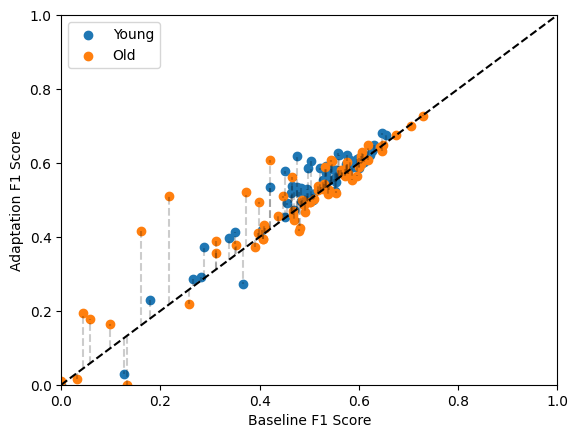

In [43]:
experiment_baseline_name = 'config_0'
experiment_adapt_thresh_name = 'config_3'

ola7_baseline = True
metric_name = 'detect_spindle_metrics' if not ola7_baseline else 'detect_spindle_metrics_ola7gt'

# For each subject, get the f1 score for baseline and for adapt threshold
baseline_f1_young = [new_dict[experiment_baseline_name][subject]['metrics'][metric_name]['f1'] for subject in subjects if int(new_dict[experiment_baseline_name][subject]['age']) <= 30]
baseline_f1_old = [new_dict[experiment_baseline_name][subject]['metrics'][metric_name]['f1'] for subject in subjects if int(new_dict[experiment_baseline_name][subject]['age']) > 30]
adapt_thresh_f1_young = [new_dict[experiment_adapt_thresh_name][subject]['metrics'][metric_name]['f1'] for subject in subjects if int(new_dict[experiment_adapt_thresh_name][subject]['age']) <= 30]
adapt_thresh_f1_old = [new_dict[experiment_adapt_thresh_name][subject]['metrics'][metric_name]['f1'] for subject in subjects if int(new_dict[experiment_adapt_thresh_name][subject]['age']) > 30]

labels = ('Young', 'Old')
scatter = [(baseline_f1_young, adapt_thresh_f1_young), (baseline_f1_old, adapt_thresh_f1_old)]

# Plot the f1 scores for each subject
fig, ax = plt.subplots()
# Change the color depending on the age of the subject
for idx, label in enumerate(labels):
    ax.scatter(scatter[idx][0], scatter[idx][1], label=label)

ax.set_xlabel('Baseline F1 Score')
ax.set_ylabel('Adaptation F1 Score')
# ax.set_title('Baseline vs AdaThreshold F1 Score')

# Add to the legend that blue is young and red is old
plt.legend()
# Draw the zero line
x = np.linspace(-10, 10, 100)
ax.plot(x, x, color='black', linestyle='--')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Shade the region under the line
# ax.fill_between(x, x, -1, color='grey', alpha=0.5)

# Draw the line between each point and the zero line
for idx in range(len(baseline_f1_young)):
    ax.plot([baseline_f1_young[idx], baseline_f1_young[idx]], [baseline_f1_young[idx], adapt_thresh_f1_young[idx]], color='black', linestyle='--', alpha=0.2)

for idx in range(len(baseline_f1_old)):
    ax.plot([baseline_f1_old[idx], baseline_f1_old[idx]], [baseline_f1_old[idx], adapt_thresh_f1_old[idx]], color='black', linestyle='--', alpha=0.2)

plt.show()

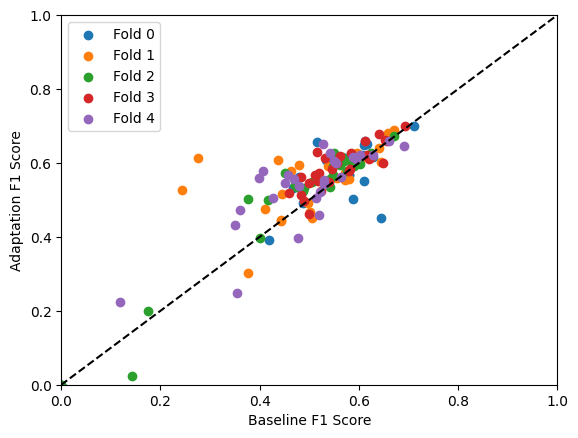

In [66]:
experiment_baseline_name = 'config_0'
experiment_adapt_thresh_name = 'config_3'

# For each subject, get the f1 score for baseline and for adapt threshold
folded_baseline = []
folded_adapt = []
for fold in range(5):
    folded_baseline.append([new_dict[experiment_baseline_name][subject]['metrics']['detect_spindle_metrics']['f1'] for subject in subjects if int(new_dict[experiment_baseline_name][subject]['config']['fold']) == fold])
    folded_adapt.append([new_dict[experiment_adapt_thresh_name][subject]['metrics']['detect_spindle_metrics']['f1'] for subject in subjects if int(new_dict[experiment_adapt_thresh_name][subject]['config']['fold']) == fold])

labels = [f"Fold {fold}" for fold in range(5)]
scatter = [(folded_baseline[fold], folded_adapt[fold]) for fold in range(5)]

# Plot the f1 scores for each subject
fig, ax = plt.subplots()
# Change the color depending on the age of the subject
for idx, label in enumerate(labels):
    ax.scatter(scatter[idx][0], scatter[idx][1], label=label)

ax.set_xlabel('Baseline F1 Score')
ax.set_ylabel('Adaptation F1 Score')
# ax.set_title('Baseline vs AdaThreshold F1 Score')

# Add to the legend that blue is young and red is old
plt.legend()
# Draw the zero line
x = np.linspace(-10, 10, 100)
ax.plot(x, x, color='black', linestyle='--')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Shade the region under the line
# ax.fill_between(x, x, -1, color='grey', alpha=0.5)

# Draw the line between each point and the zero line
# for idx in range(len(baseline_f1_young)):
#     ax.plot([baseline_f1_young[idx], baseline_f1_young[idx]], [baseline_f1_young[idx], adapt_thresh_f1_young[idx]], color='black', linestyle='--', alpha=0.2)

# for idx in range(len(baseline_f1_old)):
#     ax.plot([baseline_f1_old[idx], baseline_f1_old[idx]], [baseline_f1_old[idx], adapt_thresh_f1_old[idx]], color='black', linestyle='--', alpha=0.2)

plt.show()

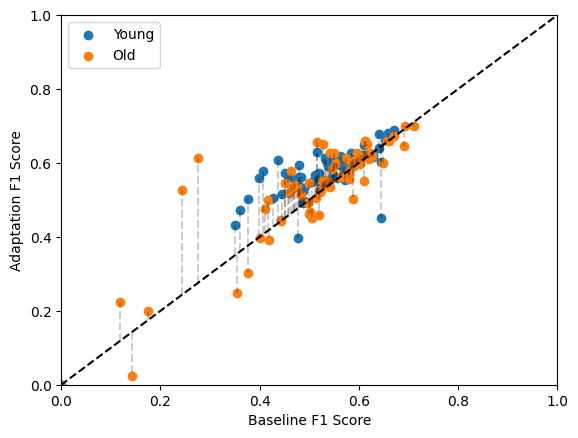

In [68]:
experiment_baseline_name = 'config_0'
experiment_adapt_thresh_name = 'config_3'

# For each subject, get the f1 score for baseline and for adapt threshold
baseline_f1_young = [new_dict[experiment_baseline_name][subject]['metrics']['detect_spindle_metrics']['f1'] for subject in subjects if int(new_dict[experiment_baseline_name][subject]['age']) <= 30]
baseline_f1_old = [new_dict[experiment_baseline_name][subject]['metrics']['detect_spindle_metrics']['f1'] for subject in subjects if int(new_dict[experiment_baseline_name][subject]['age']) > 30]
adapt_thresh_f1_young = [new_dict[experiment_adapt_thresh_name][subject]['metrics']['detect_spindle_metrics']['f1'] for subject in subjects if int(new_dict[experiment_adapt_thresh_name][subject]['age']) <= 30]
adapt_thresh_f1_old = [new_dict[experiment_adapt_thresh_name][subject]['metrics']['detect_spindle_metrics']['f1'] for subject in subjects if int(new_dict[experiment_adapt_thresh_name][subject]['age']) > 30]

labels = ('Young', 'Old')
scatter = [(baseline_f1_young, adapt_thresh_f1_young), (baseline_f1_old, adapt_thresh_f1_old)]

# Plot the f1 scores for each subject
fig, ax = plt.subplots()
# Change the color depending on the age of the subject
for idx, label in enumerate(labels):
    ax.scatter(scatter[idx][0], scatter[idx][1], label=label)

ax.set_xlabel('Baseline F1 Score')
ax.set_ylabel('Adaptation F1 Score')
# ax.set_title('Baseline vs AdaThreshold F1 Score')

# Add to the legend that blue is young and red is old
plt.legend()
# Draw the zero line
x = np.linspace(-10, 10, 100)
ax.plot(x, x, color='black', linestyle='--')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Shade the region under the line
# ax.fill_between(x, x, -1, color='grey', alpha=0.5)

# Draw the line between each point and the zero line
for idx in range(len(baseline_f1_young)):
    ax.plot([baseline_f1_young[idx], baseline_f1_young[idx]], [baseline_f1_young[idx], adapt_thresh_f1_young[idx]], color='black', linestyle='--', alpha=0.2)

for idx in range(len(baseline_f1_old)):
    ax.plot([baseline_f1_old[idx], baseline_f1_old[idx]], [baseline_f1_old[idx], adapt_thresh_f1_old[idx]], color='black', linestyle='--', alpha=0.2)
plt.savefig(figure_path + '/baseline_vs_ada_thresh_f1.png')
plt.show()


### Improvement Table

In [69]:
# Make a table with all the improvement values
improvement_data = {}
for experiment_name, experiment_data in new_dict.items():
    if experiment_name == 'config_0':
        continue
    improvement = experiment_data.get('improvement', {})
    for metric_name, item in improvement.items():
        if isinstance(item, tuple):
            avg_improvement, std_improvement, min_improvement, f1_improvement = item
            if metric_name not in improvement_data:
                improvement_data[metric_name] = []
            improvement_data[metric_name].append(f"{avg_improvement:.2f} ± {std_improvement:.2f} ({min_improvement:.2f})")

# Convert the data dictionary to a table data list
headers = ['Metric'] + list(new_dict.keys())[1:]
table_data = [[metric_name] + improvement_data[metric_name] for metric_name in improvement_data]

table = tabulate(table_data, headers, tablefmt='grid')
print(table)


+------------------+----------------------+--------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+
| Metric           | config_1             | config_2           | config_3             | config_4             | config_5             | config_6             | config_7             | config_8             |
+==================+======================+====================+======================+======================+======================+======================+======================+======================+
| f1               | 0.00 ± 0.00 (0.00)   | 0.00 ± 0.00 (0.00) | 0.03 ± 0.06 (-0.19)  | 0.02 ± 0.06 (-0.24)  | -0.01 ± 0.05 (-0.11) | -0.00 ± 0.03 (-0.07) | 0.02 ± 0.06 (-0.16)  | 0.02 ± 0.06 (-0.24)  |
+------------------+----------------------+--------------------+----------------------+----------------------+----------------------+----------------------+----------------------+---------

In [36]:
table_data_new = [headers] + table_data

# Remove all but the first three columns
table_data_new = [[row[0], row[1], row[2]] for row in table_data_new]
table_data_new[0][1] = "Adathresh (GT SS)"
table_data_new[0][2] = "Adathresh (Online SS)"

def array_to_latex(array):
    latex_code = "\\begin{table}[h!]\n"
    latex_code += "\\centering\n"
    latex_code += "\\begin{tabular}{|" + "|".join(["c"] * len(array[0])) + "|}\n"
    latex_code += "\\hline\n"
    for row in array:
        latex_code += " & ".join(map(str, row)) + " \\\\\n"
        latex_code += "\\hline\n"
    latex_code += "\\end{tabular}\n"
    latex_code += "\\caption{Caption here}\n"  # Add your caption here
    latex_code += "\\label{tab:my_table}\n"  # Add your label here
    latex_code += "\\end{table}"
    print(latex_code)

array_to_latex(table_data_new)

\begin{table}[h!]
\centering
\begin{tabular}{|c|c|c|}
\hline
Metric & Adathresh (GT SS) & Adathresh (Online SS) \\
\hline
f1 & 0.07 ± 0.10 (-0.02) & 0.07 ± 0.10 (-0.01) \\
\hline
precision & -0.02 ± 0.09 (-0.20) & -0.01 ± 0.08 (-0.17) \\
\hline
recall & 0.10 ± 0.19 (-0.10) & 0.08 ± 0.19 (-0.16) \\
\hline
ss_acc & 0.00 ± 0.00 (0.00) & 0.00 ± 0.00 (0.00) \\
\hline
wamsley_f1 & 0.00 ± 0.00 (0.00) & 0.15 ± 0.15 (0.03) \\
\hline
f1_old & 0.09 ± 0.12 (-0.02) & 0.10 ± 0.11 (0.01) \\
\hline
f1_young & 0.04 ± 0.06 (-0.01) & 0.04 ± 0.06 (-0.01) \\
\hline
wamsley_f1_old & 0.00 ± 0.00 (0.00) & 0.21 ± 0.18 (0.06) \\
\hline
wamsley_f1_young & 0.00 ± 0.00 (0.00) & 0.10 ± 0.06 (0.03) \\
\hline
\end{tabular}
\caption{Caption here}
\label{tab:my_table}
\end{table}


## Exploring Portinight Experiment 

### Figure to show average of each night

In [275]:
def portinight_experiment(folder_path, num_nights):
    experiments = {f'night{i}': [] for i in range(num_nights)}

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.json'):
            file_path = os.path.join(folder_path, file_name)
            # Check that we have the output for workers 0-3
            # print(file_path[-7:-5] )
            if not file_path[-7:-5] in [f'r{i}' for i in range(5)]:
                continue
            with open(file_path, 'r') as file:
                data = json.load(file)
                nights = list(experiments.keys())
                print(data.keys())
                assert len(nights) == num_nights
                for index, (_, subject_data) in enumerate(data.items()):
                    experiments[nights[index]].append(subject_data)
    return experiments

In [276]:
portinight_experiment_dict = portinight_experiment(path_portinight, 3)

dict_keys(['PN_01_HJ_Night1', 'PN_01_HJ_Night3', 'PN_01_HJ_Night4'])
dict_keys(['PN_02_MS_Night2', 'PN_02_MS_Night3', 'PN_02_MS_Night4'])
dict_keys(['PN_02_MS_Night4', 'PN_03_CL_Night3', 'PN_02_MS_Night3'])
dict_keys(['PN_07_CB_NightD', 'PN_07_CB_NightE', 'PN_07_CB_NightF'])
dict_keys(['PN_03_CL_Night3', 'PN_03_CL_Night4', 'PN_03_CL_Night6'])


In [277]:
for exp in portinight_experiment_dict['night0']:
    print(exp['config_0']['metrics']['detect_spindle_metrics']['f1'])

0.2241183140760119
0.3292547244399089
0.20462675662923607
0.12584522776926413
0.15910780476776165


In [278]:
# Get the list of f1 score for each config for each night
num_nights = 3
f1_scores = []
for index, (night, night_data) in enumerate(portinight_experiment_dict.items()):
    f1_scores.append({})
    for idx, experiment in enumerate(night_data):
        for config_name, _ in experiment.items():
            if config_name not in f1_scores[index]:
                f1_scores[index][config_name] = []
            f1_score = experiment[config_name]['metrics']['detect_spindle_metrics']['f1']
            f1_scores[index][config_name].append(f1_score)


# Get the average f1 score for each config for each night
average_f1_scores = []
for index, night in enumerate(f1_scores):
    average_f1_scores.append({})
    for config_name, f1s in night.items():
        average_f1_scores[index][config_name] = np.mean(f1s)

# # Get the std f1 score for each config for each night
std_f1_scores = []
for index, night in enumerate(f1_scores):
    std_f1_scores.append({})
    for config_name, f1s in night.items():
        std_f1_scores[index][config_name] = np.std(f1s)


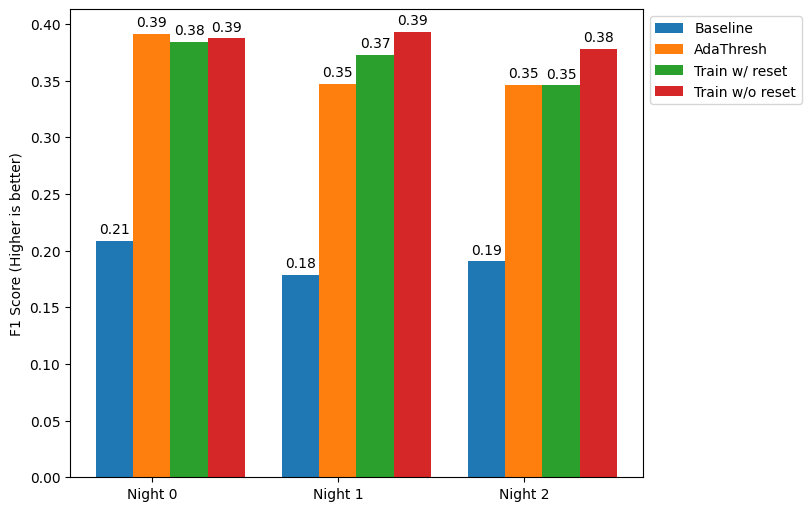

In [279]:
import numpy as np
import matplotlib.pyplot as plt

# Do a bar plot of the average f1 scores for each night for configs 0, 1, 4, 5 with a different color for each config
config_names = ("config_0", "config_1", "config_4", "config_5")
labels = ("Baseline", "AdaThresh", "Train w/ reset", "Train w/o reset")

# Get the average f1 scores for each config for each night
average_f1_scores = []
for index, night in enumerate(f1_scores):
    average_f1_scores.append({})
    for config_name, f1s in night.items():
        average_f1_scores[index][config_name] = np.mean(f1s)

x = np.arange(len(portinight_experiment_dict.keys()))
width = 0.20
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(8, 5))

for idx, config_name in enumerate(config_names):
    scores = [average_f1_scores[i][config_name] for i in range(num_nights)]
    offset = width * multiplier
    rects = ax.bar(x + offset, scores, width, label=labels[idx])
    ax.bar_label(rects, padding=3, fmt='%.2f')
    multiplier += 1
    # Add the std deviation to the plot


ax.set_ylabel('F1 Score (Higher is better)')
ax.set_xticks(x + width, [f"Night {i}" for i in range(num_nights)])

# Move the legend outside of the figure
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


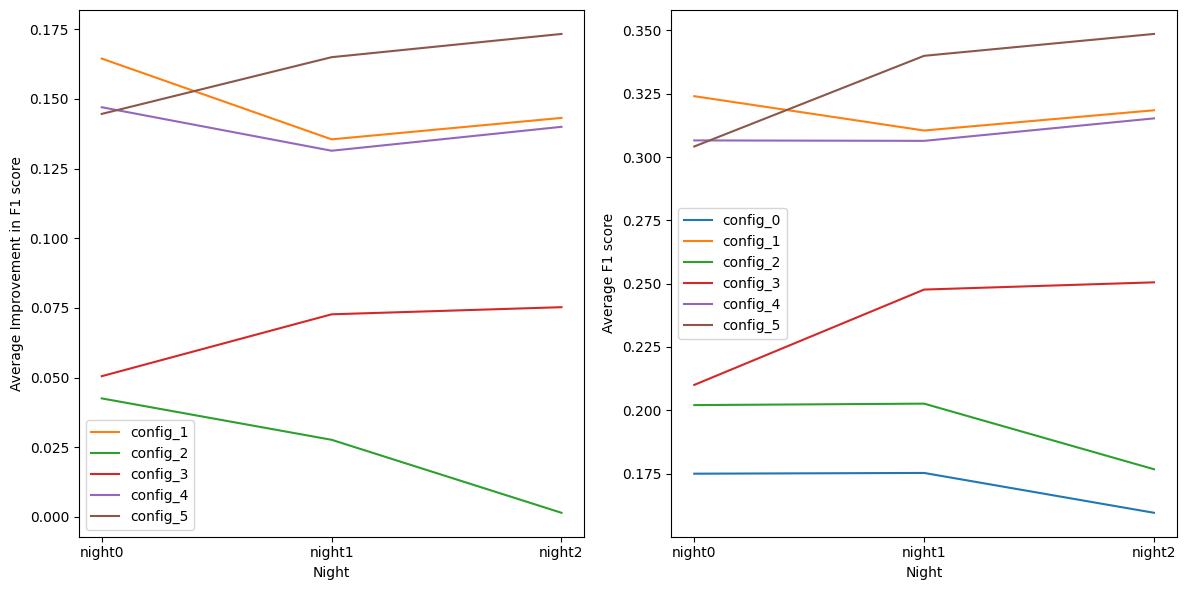

In [32]:
import matplotlib.pyplot as plt

# Plot the improvements with x axis being the nights and y axis being the improvement for each config in a different color
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

colors = plt.cm.tab10.colors  # Using a predefined color map for consistent colors

for idx, experiment_name in enumerate(experiment_dict.keys()):
    if experiment_name == 'config_0':
        continue
    improvement_vals = [improvement[night][experiment_name][0] for night in improvement]
    ax1.plot(list(improvement.keys()), improvement_vals, label=experiment_name, color=colors[idx])

ax1.set_xlabel('Night')
ax1.set_ylabel('Average Improvement in F1 score')
ax1.legend()

# Plot the values of f1 score in a plot next to the improvement plot
for idx, experiment_name in enumerate(experiment_dict.keys()):
    f1_vals = [night_averages[night][experiment_name][0] for night in night_averages]
    ax2.plot(list(night_averages.keys()), f1_vals, label=experiment_name, color=colors[idx])

ax2.set_xlabel('Night')
ax2.set_ylabel('Average F1 score')
ax2.legend()

plt.tight_layout()
plt.show()



TypeError: tuple indices must be integers or slices, not str

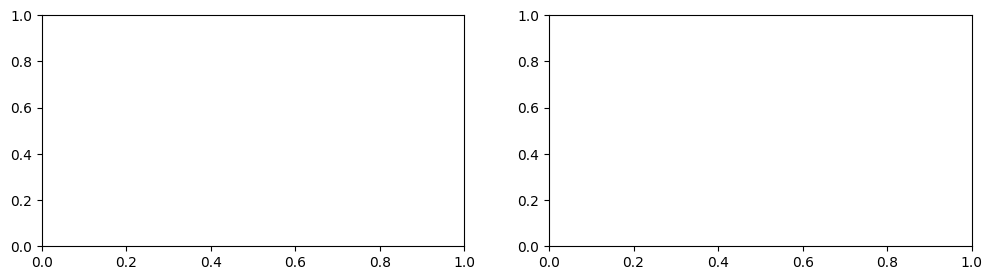

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the improvements with x axis being the nights and y axis being the improvement for each config in a different color
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

colors = plt.cm.tab10.colors  # Using a predefined color map for consistent colors
bar_width = 0.1
night_indices = np.arange(len(improvement))
labels = [
    'Baseline',
    'AdaThresh',
    'Learn (w/ reset)',
    'Learn (w/o reset)',
    'Both (w/ reset)',
    'Both (w/o reset)',
]

for idx, experiment_name in enumerate(experiment_dict.keys()):
    if experiment_name == 'config_0':
        continue
    improvement_vals = [improvement[night][experiment_name][0] for night in improvement]
    ax1.bar(night_indices + idx * bar_width, improvement_vals, bar_width, label=labels[idx], color=colors[idx])

ax1.set_ylabel('Average Improvement in F1 score')
# Set both plots to have the same x axis
ax1.set_xticks(night_indices + 2 * bar_width)
ax1.set_xticklabels(['Night 1', 'Night 2', 'Night 3'])

# Plot the values of f1 score in a plot next to the improvement plot
for idx, experiment_name in enumerate(experiment_dict.keys()):
    f1_vals = [night_averages[night][experiment_name][0] for night in night_averages]
    ax2.bar(night_indices + idx * bar_width, f1_vals, bar_width, label=labels[idx], color=colors[idx])

ax2.set_ylabel('Average F1 score')
ax2.legend()

# Move the legend outside of the plot
# ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))

ax2.set_xticks(night_indices + 2 * bar_width)
ax2.set_xticklabels(['Night 1', 'Night 2', 'Night 3'])

plt.tight_layout()
plt.show()


## Checking that our baseline has high spindle power in ground truth spindles

In [5]:
from portiloopml.portiloop_python.ANN.data.mass_data_new import MassConsecutiveSampler, MassDataset, SubjectLoader

# Load all the subjects and their data
dataset_path = '/project/MASS/mass_spindles_dataset'
loader = SubjectLoader(
    os.path.join(dataset_path, 'subject_info.csv'))
subjects = loader.select_all_subjects()

Time taken to load 01-01-0029: 1.1537182331085205
Time taken to create lookup table: 0.699439525604248
Number of sampleable indices: 8031447
Number of spindles: 0
Number of N1: 0
Number of N2: 0
Number of N3: 0
Number of R: 0
Number of W: 0


Mean: 1733318.4149633525 | Std: 261546277.43092024 | len: 3645000
Subject 01-01-0029 had 55 spindles, now found 55 and is 57 years old


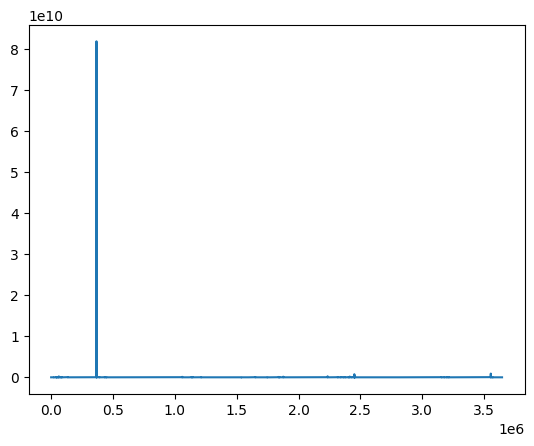

In [7]:
import copy
from portiloopml.portiloop_python.ANN.wamsley_utils import _detect_start_end, _merge_close, detect_wamsley, morlet_transform, remove_straddlers, smooth, within_duration

ages = []
num_spindles = []
means = []
stds = []

interest_subjet = "01-01-0029"

for subject in subjects:

    if subject != interest_subjet:
        continue

    dataset = MassDataset(
        dataset_path,
        subjects=[subject],
        window_size=54,
        seq_stride=42,
        seq_len=1,
        use_filtered=False,
        sampleable='none')
    
    signal = dataset.data[subject]['signal']
    spindle_labels = dataset.data[subject]['spindle_label']
    ss_labels = dataset.data[subject]['ss_label']

    mask = (ss_labels == 1) | (ss_labels == 2)


    num_spindle = len(dataset.data[subject]['spindle_label_mass'][subject]['onsets'])
    age = int(dataset.data[subject]['age'])

    ages.append(age)
    num_spindles.append(num_spindle)
    
    # print(len(signal))

    # break

    # signal = signal[1100000:]
    # mask = mask[1100000:]

    sampling_rate = 250
    thresholds = None
    data = signal

    frequency = (11, 16)
    duration = (0.3, 3)
    wavelet_options = {'f0': np.mean(frequency),
                       'sd': .8,
                       'dur': 1.,
                       'output': 'complex'
                       }
    smooth_duration = .1
    det_thresh = 4.5
    merge_thresh = 0.3
    min_interval = 0.5  # minimum time in seconds between events

    thresholds = copy.deepcopy(thresholds)

    # First, we transform the signal using wavelet transform
    if mask is None:
        data_detect = data
    else:
        data_detect = data[mask]

    # If the data is too short, return an empty array
    if len(data_detect) <= 30 * 250:
        break
    #     return np.array([]), None, None, None, thresholds

    if mask is None:
        timestamps = np.arange(0, len(data)) / sampling_rate
    else:
        timestamps = (np.arange(0, len(data)))[mask] / sampling_rate
    assert len(data_detect) == len(timestamps)
    data_detect = morlet_transform(data_detect, sampling_rate, wavelet_options)
    data_detect = np.real(data_detect ** 2) ** 2

    # Then we smoothen out the signal
    data_detect = smooth(data_detect, sampling_rate, smooth_duration)

    # We take the absolute value of the signal
    # data_detect = np.abs(data_detect)

    mean_spindle_power = np.mean(data_detect)

    # # We first keep only low spindle power
    # data_detect_low_pow = data_detect[data_detect < mean_spindle_power * 10]

    # print(f"Low power signal represents {len(data_detect_low_pow) / len(data_detect) * 100:.2f}% of the signal")

    # # From that lower power, we compute the mean to get our threshold
    # mean_spindle_power = np.mean(data_detect_low_pow)

    # Then, we define the threshold
    _threshold = det_thresh * mean_spindle_power
    if thresholds is None:
        threshold = _threshold
    else:
        thresholds.append((_threshold, len(data_detect)))

        # Compute the weighted average of the thresholds to get the current threshold
        weigths = np.array([i[1] for i in thresholds])
        weigths = weigths / np.sum(weigths)
        threshold = np.sum([i[0] * j for i, j in zip(thresholds, weigths)])

    # Then we find the peaks
    peaks = data_detect >= threshold

    # Get the start, end and peak power index of each spindle
    events = _detect_start_end(peaks)

    # If no events are found, return an empty array
    if events is None:
        print("No events")
        break
        # return np.array([]), _threshold, threshold, data_detect, thresholds

    # add the location of the peak in the middle
    events = np.insert(events, 1, 0, axis=1)
    for i in events:
        i[1] = i[0] + np.argmax(data_detect[i[0]:i[2]])

    # Merge the events that are too close
    events = _merge_close(data_detect, events, timestamps, min_interval)
    # Filter the events based on duration
    events = within_duration(events, timestamps, duration)
    # Remove the events that straddle a stitch
    events = remove_straddlers(events, timestamps, sampling_rate)

    # Get the real indexes back
    def to_index(point):
        return timestamps[point] * sampling_rate

    if len(events) == 0:
        break
        # return np.array([]), _threshold, threshold, data_detect, thresholds

    events = np.vectorize(to_index)(events)

    spindles = events.astype(int)

    num_spindle_new = len(spindles)

    plt.plot(data_detect)

    print(f"Mean: {np.mean(data_detect)} | Std: {np.std(data_detect)} | len: {len(data_detect)}")
    # means.append(np.mean(data_detect))
    # stds.append(np.std(data_detect))

    print(f"Subject {subject} had {num_spindle} spindles, now found {num_spindle_new} and is {age} years old")


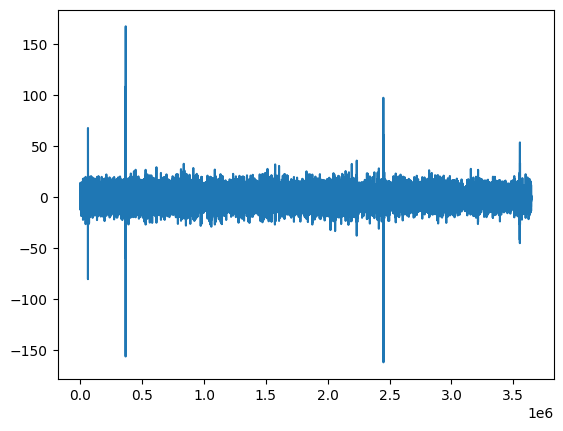

In [12]:
plt.plot(data_detect)

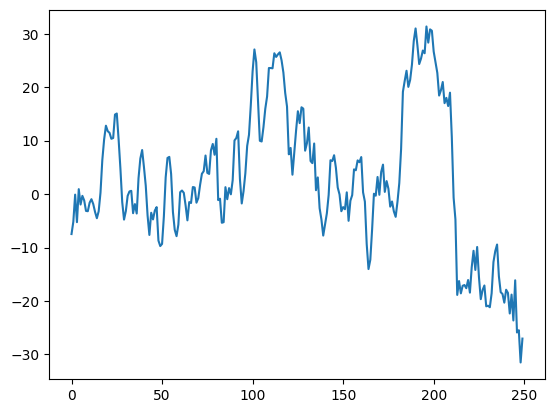

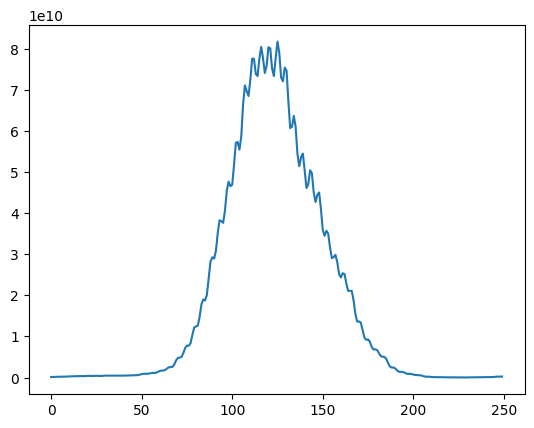

In [10]:
diff = 125
plt.plot(signal[np.argmax(data_detect)-diff:np.argmax(data_detect)+diff])
plt.show()
plt.plot(data_detect[np.argmax(data_detect)-diff:np.argmax(data_detect)+diff])

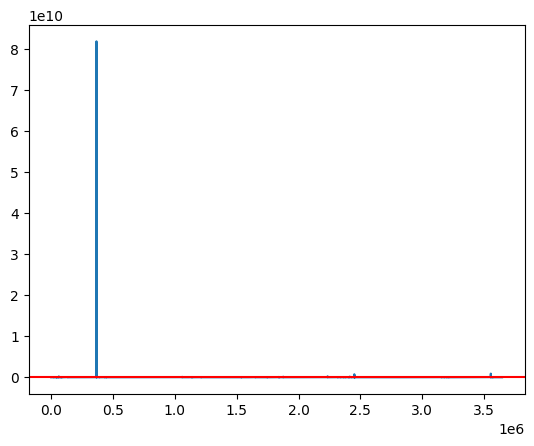

In [46]:
plt.plot(data_detect)
# Plot a horizontal line at the mean of the signal
plt.axhline(y=np.mean(data_detect) * 4.5, color='r', linestyle='-')

In [37]:
np.mean(stds)

22073055.07208123

Pearson correlation coefficient: -0.5441057037344059
P-value: 3.097693346346595e-12


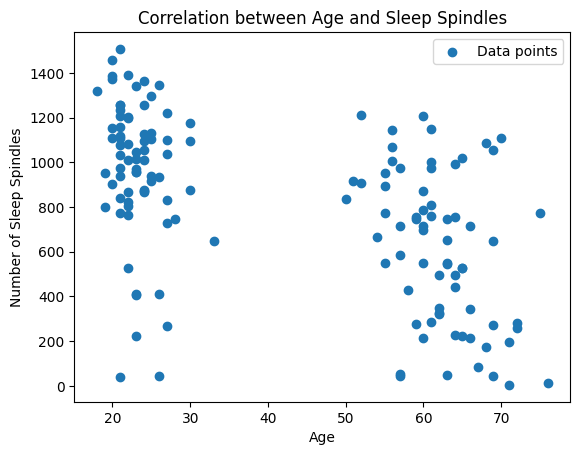

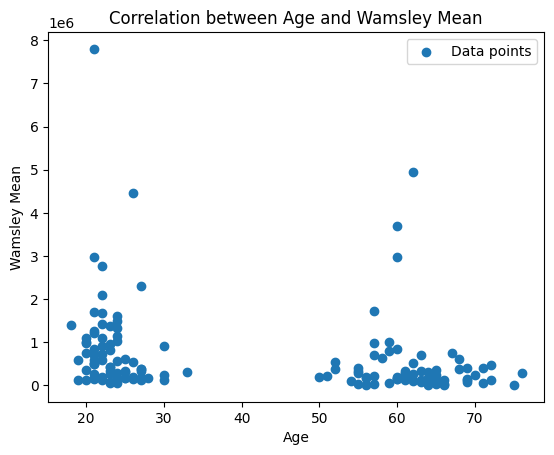

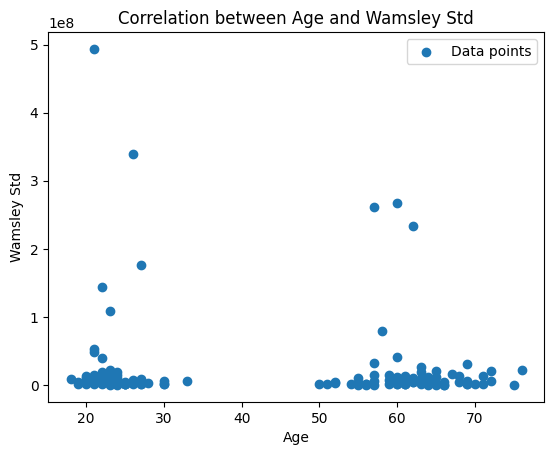

<Figure size 640x480 with 0 Axes>

In [33]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Calculate Pearson correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(ages, num_spindles)

# Print the results
print(f"Pearson correlation coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

# Plot the data
plt.scatter(ages, num_spindles, label='Data points')
plt.title('Correlation between Age and Sleep Spindles')
plt.xlabel('Age')
plt.ylabel('Number of Sleep Spindles')
plt.legend()
plt.show()
plt.clf()

plt.scatter(ages, means, label='Data points')
plt.title('Correlation between Age and Wamsley Mean')
plt.xlabel('Age')
plt.ylabel('Wamsley Mean')
plt.legend()
plt.show()
plt.clf()

plt.scatter(ages, stds, label='Data points')
plt.title('Correlation between Age and Wamsley Std')
plt.xlabel('Age')
plt.ylabel('Wamsley Std')
plt.legend()
plt.show()
plt.clf()


## Old Stuff

In [10]:
experiment_dict['BASELINE_NOTHING']['01-03-0018']['metrics'].keys()

dict_keys(['ss_metrics', 'ss_confusion_matrix', 'detect_spindle_metrics', 'online_wamsley_metrics', 'multi_threshold_metrics', 'used_thresholds', 'training_losses'])

Get the statistics of the Sleep Staging Performance Over the 20 subjects

In [4]:
experiment = experiment_dict['first_baseline_notrain']
accuracies = []
f1_N2 = []
f1_N3 = []
f1_wake = []
cms = []
for subject in experiment.keys():
    # print(experiment[subject]['metrics'])
    accuracies.append(experiment[subject]['metrics']['ss_metrics']['accuracy'])
    f1_N2.append(experiment[subject]['metrics']['ss_metrics']['1']['f1-score'])
    f1_N3.append(experiment[subject]['metrics']['ss_metrics']['2']['f1-score'])
    f1_wake.append(experiment[subject]['metrics']['ss_metrics']['4']['f1-score'])
    cms.append(experiment[subject]['metrics']['ss_confusion_matrix'])

In [5]:
import numpy as np
average_accuracy = np.mean(accuracies)
print(average_accuracy)
# Get the standard deviation of the accuracies
std_accuracy = np.std(accuracies)
print(std_accuracy)

0.706734328806407
0.09711451554230675


In [6]:
average_f1_n2 = np.mean(f1_N2)
print(average_f1_n2)
# Get the standard deviation of the accuracies
std_f1_n2 = np.std(f1_N2)
print(std_f1_n2)

average_f1_n3 = np.mean(f1_N3)
print(average_f1_n3)
# Get the standard deviation of the accuracies
std_f1_n3 = np.std(f1_N3)
print(std_f1_n3)


0.764797138169081
0.12199061645731106
0.3308269481436845
0.30305245267389275


In [7]:
average_f1_wake = np.mean(f1_wake)
print(average_f1_wake)
# Get the standard deviation of the accuracies
std_f1_wake = np.std(f1_wake)
print(std_f1_wake)

0.7188188376883453
0.1602445520403144


In [8]:
cms = np.array(cms)
# Sum along the first axis
cms = np.sum(cms, axis=0)

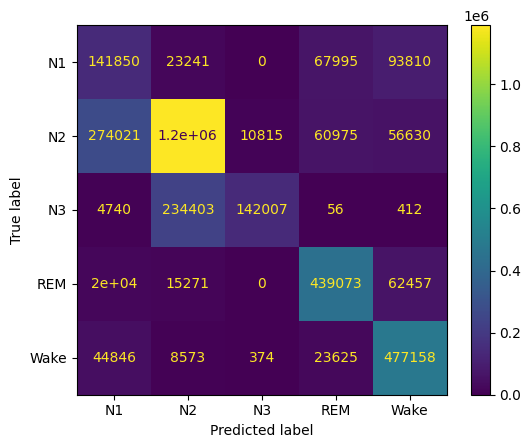

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay


disp = ConfusionMatrixDisplay(confusion_matrix=cms,
                              display_labels=['N1', 'N2', 'N3', 'REM', 'Wake'])
disp.plot()

We get the baseline performace of the Spindle detection

In [14]:
experiment = experiment_dict['real_baseline_nothing']
f1_scores = []
precisions = []
recalls = []
for subject in experiment.keys():
    # print(experiment[subject]['metrics'].keys())
    f1_scores.append(experiment[subject]['metrics']['detect_spindle_metrics']['f1'])
    precisions.append(experiment[subject]['metrics']['detect_spindle_metrics']['precision'])
    recalls.append(experiment[subject]['metrics']['detect_spindle_metrics']['recall'])

In [16]:
print(np.average(f1_scores))
print(np.std(f1_scores))
print(np.average(precisions))
print(np.std(precisions))
print(np.average(recalls))
print(np.std(recalls))

0.4836005888411341
0.17485666001141167
0.36297551882286916
0.15008619439999116
0.8512610319767475
0.12392935815112163


In [17]:
f1_scores

[0.5961538418133695,
 0.6167524519558489,
 0.5203182071929582,
 0.09478672886952226,
 0.5135213686028951,
 0.6386321578412205,
 0.4050393656121243]

Get two different models F1 score curve depending on threshold

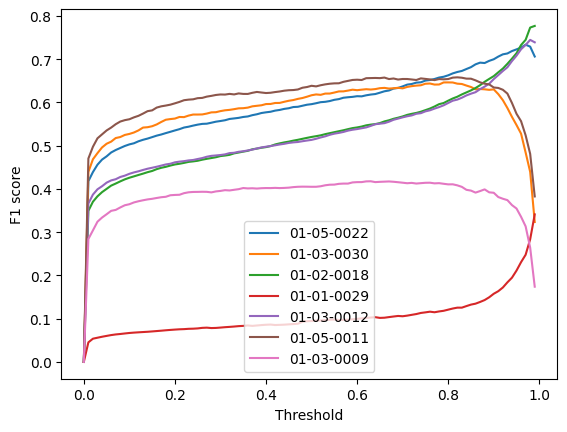

In [13]:
experiment = experiment_dict['real_baseline_nothing']

for subject in experiment.keys():
    subject_data = experiment[subject]['metrics']['multi_threshold_metrics']
    f1s = np.array(list(subject_data.values()))
    thresholds = np.array(list(subject_data.keys()), dtype=float)
    plt.plot(thresholds, f1s, label=subject)

plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.legend()
plt.show()
# subject_1 = '01-03-0038'
# subject_2 = '01-03-0018'



Get metrics for the modified Wamsley 

In [30]:
experiment = experiment_dict['first_baseline_notrain']

f1s = []
precisions = []
recalls = []
ss_acc = []

for subject in experiment.keys():
    print(f"Subject {subject} has f1 score {experiment[subject]['metrics']['online_wamsley_metrics']['f1']} and accuracy {experiment[subject]['metrics']['ss_metrics']['accuracy']}")
    data = experiment[subject]['metrics']['online_wamsley_metrics']
    f1s.append(data['f1'])
    precisions.append(data['precision'])
    recalls.append(data['recall'])

    ss_acc.append(experiment[subject]['metrics']['ss_metrics']['accuracy'])


Subject 01-01-0031 has f1 score 0.8380237598537392 and accuracy 0.7456494671802936
Subject 01-01-0029 has f1 score 0.17469879241635217 and accuracy 0.6693668193017099
Subject 01-03-0038 has f1 score 0.7695924716629776 and accuracy 0.7403877793022953
Subject 01-03-0031 has f1 score 0.6923924981006178 and accuracy 0.5522692979772578
Subject 01-03-0009 has f1 score 0.5491698551817682 and accuracy 0.6297657272668572
Subject 01-05-0019 has f1 score 0.9337686517214477 and accuracy 0.7866238204646441
Subject 01-03-0010 has f1 score 0.9132149851544259 and accuracy 0.8058820444387467
Subject 01-03-0030 has f1 score 0.8088642610482961 and accuracy 0.6705810218978102
Subject 01-03-0012 has f1 score 0.9293981431617115 and accuracy 0.7167529411764706
Subject 01-03-0018 has f1 score 0.6845965720776419 and accuracy 0.6458660664996391
Subject 01-01-0004 has f1 score 0.01544401529076788 and accuracy 0.4513090909090909
Subject 01-01-0008 has f1 score 0.5370629328025821 and accuracy 0.6772754147005343
Su

In [28]:
print(np.average(f1s))
print(np.std(f1s))
print(np.average(precisions))
print(np.std(precisions))
print(np.average(recalls))
print(np.std(recalls))

0.707488154477859
0.2465086616727925
0.8608009166067896
0.20032584547016885
0.67224427044443
0.24564489293428907


In [23]:
ss_acc[10]

0.4513090909090909

Get the Single threshold data vs thrshold selection

In [60]:
experiment = experiment_dict['first_baseline_notrain']

f1s_imp1 = []
precisions = []
recalls = []
ss_acc = []

for subject in experiment.keys():
    print(f"Subject {subject} has f1 score {experiment[subject]['metrics']['detect_spindle_metrics']['f1']} and accuracy {experiment[subject]['metrics']['ss_metrics']['accuracy']}")
    data = experiment[subject]['metrics']['detect_spindle_metrics']
    f1s_imp1.append(data['f1'])
    precisions.append(data['precision'])
    recalls.append(data['recall'])

    ss_acc.append(experiment[subject]['metrics']['ss_metrics']['accuracy'])

Subject 01-01-0031 has f1 score 0.6363636313874723 and accuracy 0.7456494671802936
Subject 01-01-0029 has f1 score 0.1825242699368461 and accuracy 0.6693668193017099
Subject 01-03-0038 has f1 score 0.6607387090966127 and accuracy 0.7403877793022953
Subject 01-03-0031 has f1 score 0.062394603042451424 and accuracy 0.5522692979772578
Subject 01-03-0009 has f1 score 0.3599523195712232 and accuracy 0.6297657272668572
Subject 01-05-0019 has f1 score 0.7426981869364915 and accuracy 0.7866238204646441
Subject 01-03-0010 has f1 score 0.6777251137832084 and accuracy 0.8058820444387467
Subject 01-03-0030 has f1 score 0.6365914737069177 and accuracy 0.6705810218978102
Subject 01-03-0012 has f1 score 0.7226519287017553 and accuracy 0.7167529411764706
Subject 01-03-0018 has f1 score 0.5440414457934442 and accuracy 0.6458660664996391
Subject 01-01-0004 has f1 score 0.28260869143918366 and accuracy 0.4513090909090909
Subject 01-01-0008 has f1 score 0.4945188746272111 and accuracy 0.6772754147005343
S

In [61]:
print(np.average(f1s_imp1))
print(np.std(f1s_imp1))
print(np.average(precisions))
print(np.std(precisions))
print(np.average(recalls))
print(np.std(recalls))

0.549921582386626
0.18897477323021863
0.6197975874594737
0.16551430651405652
0.5818990126025465
0.22566586547245715


Text(0.5, 1.0, '01-03-0031')

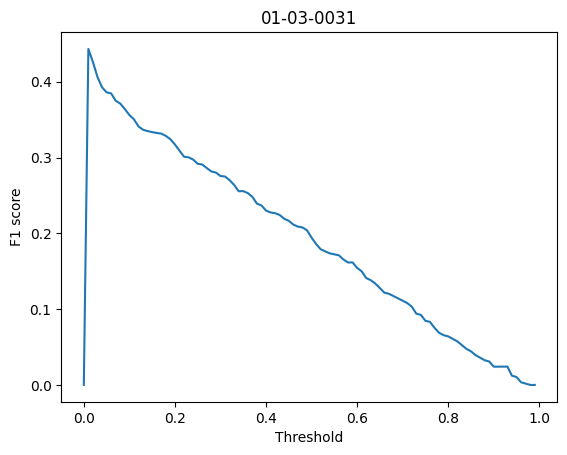

In [68]:
experiment = experiment_dict['training_all_natural']

# Show the plot of the thresholds and f1 scores
thresholds = np.array(list(experiment['01-03-0031']['metrics']['multi_threshold_metrics'].keys()), dtype=float)
f1s = np.array(list(experiment['01-03-0031']['metrics']['multi_threshold_metrics'].values()))
plt.plot(thresholds, f1s, label=subject)
plt.xlabel('Threshold')
plt.ylabel('F1 score')
# Add a title
plt.title('01-03-0031')

Text(0.5, 1.0, '01-03-0030')

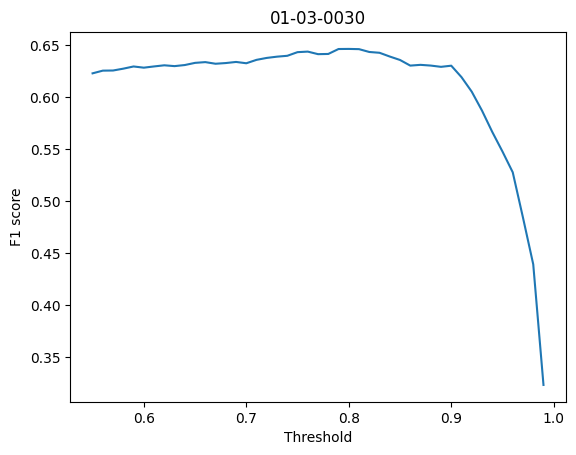

In [76]:
experiment = experiment_dict['first_baseline_notrain']
thresholds = np.array(list(experiment['01-03-0030']['metrics']['multi_threshold_metrics'].keys()), dtype=float)
f1s = np.array(list(experiment['01-03-0030']['metrics']['multi_threshold_metrics'].values()))
plt.plot(thresholds, f1s, label=experiment)
plt.xlabel('Threshold')
plt.ylabel('F1 score')
# Add a title
plt.title('01-03-0030')

Get the data for a single training

Text(0.5, 1.0, 'Training loss over time')

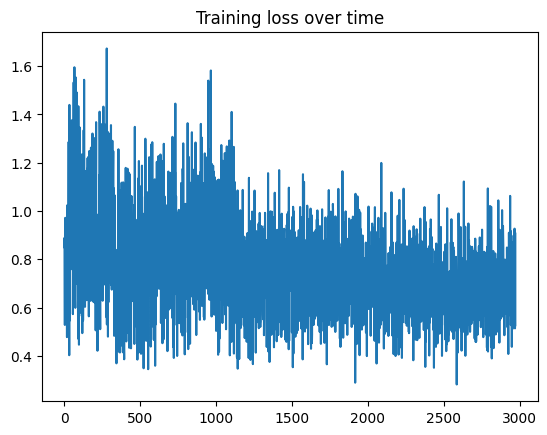

In [69]:
experiment = experiment_dict['training_all_natural']

plt.plot(experiment['01-03-0031']['metrics']['training_losses'])
# ADd a title
plt.title('Training loss over time')

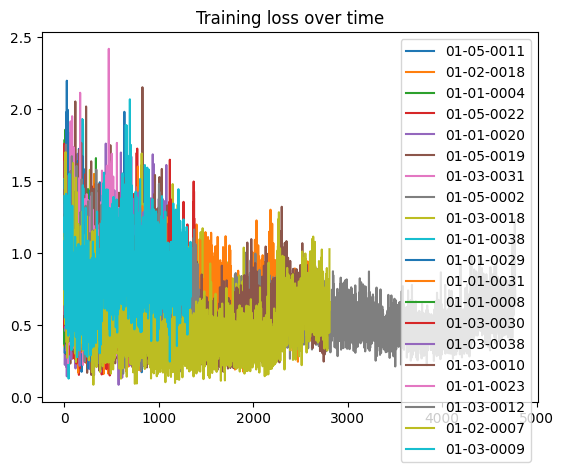

In [71]:

experiment = experiment_dict['first_test_train']
# Plot the training loss
for subject in experiment.keys():
    plt.plot(experiment[subject]['metrics']['training_losses'], label=subject)
    # ADd a title
plt.title('Training loss over time')
plt.legend()
plt.show()

In [72]:
# Get all the f1s 
f1s = []
for subject in experiment.keys():
    f1s.append(experiment[subject]['metrics']['detect_spindle_metrics']['f1'])

In [73]:
# Plot the f1 scores
np.average(f1s)

0.5085186010058762